# Setup

In [1]:
%config Completer.use_jedi = False

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import Data

In [3]:
from typing import Dict

def prepare_data(
    boards: Dict[str, pd.DataFrame], 
    adjacency: Dict[str, pd.DataFrame],
):
    board_data = ['board', 'id']
    setup_data = [
        'dahan', 'explorers', 'towns', 'cities', 'blight', 
        'beasts', 'wilds', 'disease', 'strife', 'badlands',
    ]
    
    nodes = list()
    for name, df in boards.items():
        df['defence'] = 0
        df[board_data] = df[board_data].ffill()
        df[setup_data] = df[setup_data].fillna(0).astype(int)
        df['node'] = list(zip(df['board'], df['id']))
        df = df.set_index('node')
        nodes.append(df)
    nodes = pd.concat(nodes)
    
    edges = list()
    for name, df in adjacency.items():
        df = df.ffill().astype(int, errors='ignore')
        df['source'] = list(zip(df['source_board'], df['source_id']))
        df['target'] = list(zip(df['target_board'], df['target_id']))
        df = df.set_index(['source', 'target'])
        edges.append(df)
    edges = pd.concat(edges)
    
    return nodes, edges

boards = pd.read_excel('boards.xlsx', sheet_name=None)
boards = pd.Series(boards)

adjacency = pd.read_excel('adjacency.xlsx', sheet_name=None)
adjacency = pd.Series(adjacency)

nodes, edges = prepare_data(
    boards = boards[['northwest', 'northeast', 'west', 'east']].to_dict(),
    adjacency = adjacency[['northwest', 'northeast', 'west', 'east', 'thematic']].to_dict(),
)

In [4]:
nodes.head()

,board,id,land,dahan,explorers,towns,cities,blight,beasts,wilds,disease,strife,badlands,defence
node,,,,,,,,,,,,,,
"(northwest, 0)",northwest,0,O,0,0,0,0,0,0,0,0,0,0,0
"(northwest, 1)",northwest,1,S,1,2,0,0,0,0,0,0,0,0,0
"(northwest, 2)",northwest,2,S,0,0,0,1,0,0,0,0,0,0,0
"(northwest, 3)",northwest,3,W,0,0,1,0,0,0,0,1,0,0,0
"(northwest, 4)",northwest,4,J,0,0,0,0,0,0,0,0,0,0,0


In [5]:
edges.head()

source_board target_board  source_id  target_id
source         target                                                        
(northwest, 0) (northwest, 1)    northwest    northwest          0          1
               (northwest, 2)    northwest    northwest          0          2
               (northwest, 3)    northwest    northwest          0          3
(northwest, 1) (northwest, 2)    northwest    northwest          1          2
               (northwest, 5)    northwest    northwest          1          5

# Load data into network

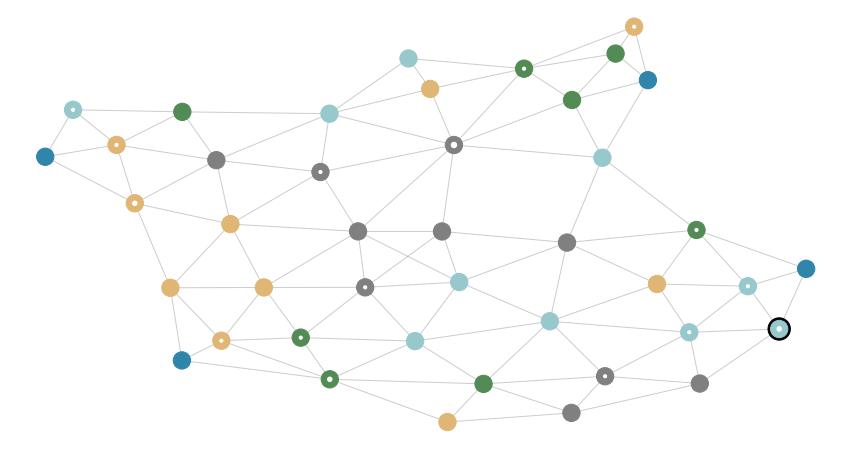

In [6]:
import networkx as nx

board = nx.Graph()
board.add_nodes_from(nodes.index)
board.add_edges_from(edges.index)

for node_attr in nodes:
    nx.set_node_attributes(board, nodes[node_attr], node_attr)

# Try to find a nice network layout
pos = nx.spring_layout(
    board, 
    iterations = 100, 
    pos = {
        ('northwest', 3): (0, 10),
        ('northeast', 1): (10, 10),
        ('west', 1): (0, 0), 
        ('east', 3): (0, 10), 
    }, 
    seed = 5,
)

# Assign colours (oof these are v ugly gotta replace with proper hex codes soon)
colors = pd.Series({
    'O': '#3085AA',
    'J': '#538B56',
    'M': '#808080',
    'S': '#DFB674',
    'W': '#96C8CC',
}).reindex(nodes['land'])

blight_count = (nodes['blight'] > 0)
invader_count = nodes[['explorers', 'towns', 'cities']].sum(axis=1)

# Trial plot
plt.figure(figsize=(15, 8))
edge_plot = nx.draw_networkx_edges(board, pos, alpha=0.2)
node_plot = nx.draw_networkx_nodes(board, pos, node_color='black', node_size=500*blight_count)
node_plot = nx.draw_networkx_nodes(board, pos, node_color=colors)
node_plot = nx.draw_networkx_nodes(board, pos, node_color='white', node_size=10*invader_count)
plt.axis('off')
plt.show()

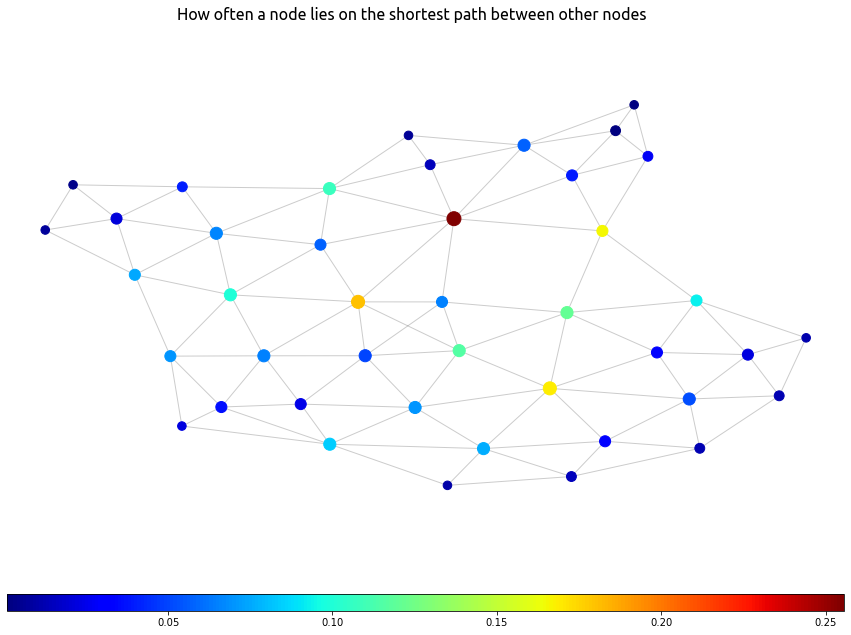

In [7]:
# How often a node lies on the shortest path between other nodes
c_b = pd.Series(nx.betweenness_centrality(board))

# How close a node is to other nodes on average
c_c = pd.Series(nx.closeness_centrality(board))

# How connected a node is
c_d = pd.Series(nx.degree_centrality(board))

plt.figure(figsize=(15, 11))
edge_plot = nx.draw_networkx_edges(board, pos, alpha=0.2)
node_plot = nx.draw_networkx_nodes(
    board, pos, board.nodes, 
    node_color = c_b,
    node_size = 1000*c_d,
    cmap = plt.cm.jet,
)

plt.colorbar(node_plot, orientation='horizontal', aspect=50)
plt.suptitle('How often a node lies on the shortest path between other nodes', font='Ubuntu', fontsize=16)
plt.axis('off')
plt.show()

# Simulate game

Start
--------------------------------------------------------------------------------


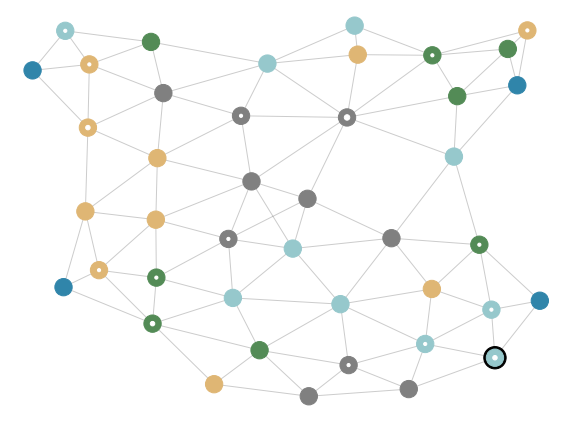


J+M Explore
--------------------------------------------------------------------------------


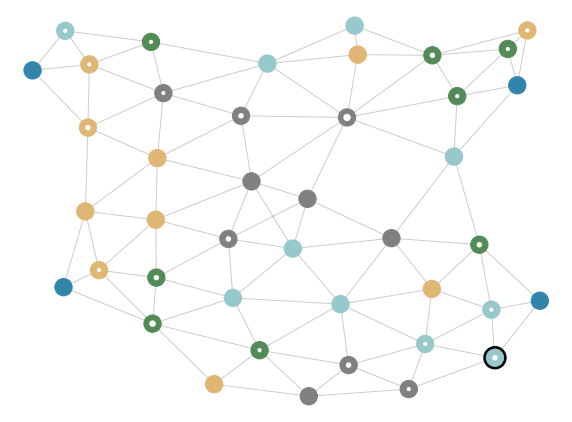


J+M Build
--------------------------------------------------------------------------------


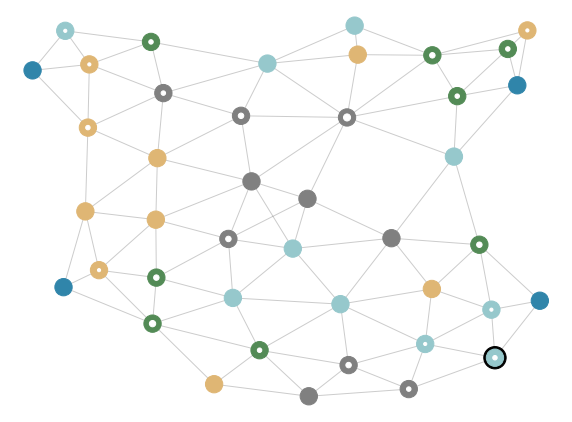


J+M Ravage
--------------------------------------------------------------------------------


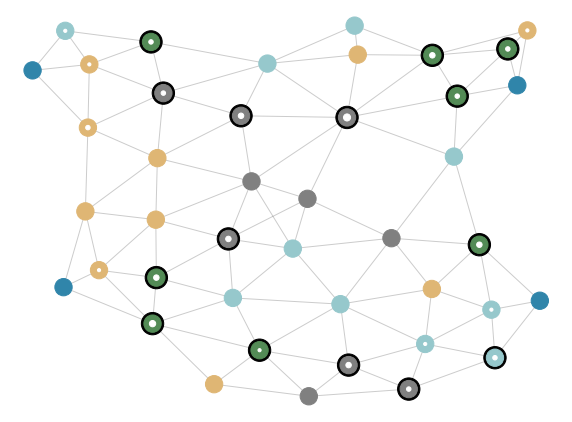


J+W Explore
--------------------------------------------------------------------------------


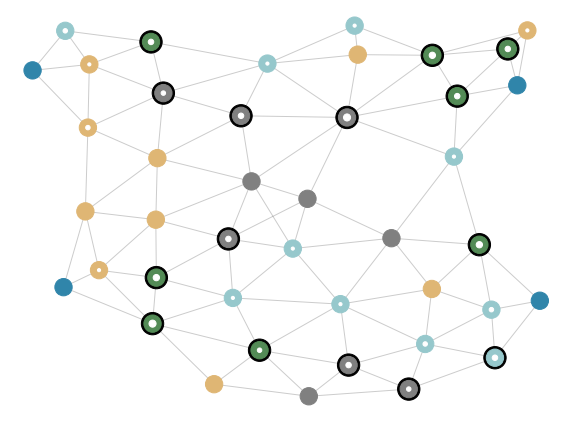


J+W Build
--------------------------------------------------------------------------------


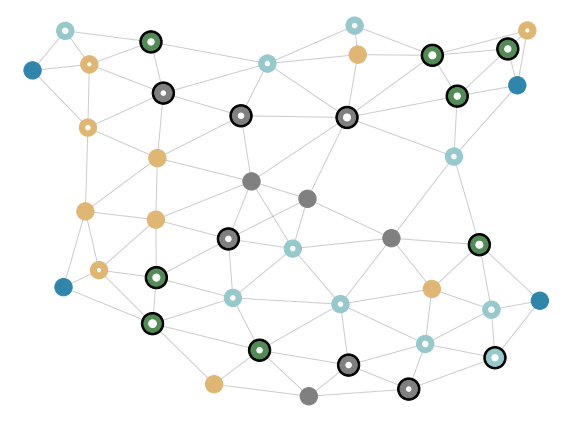


J+W Ravage
--------------------------------------------------------------------------------


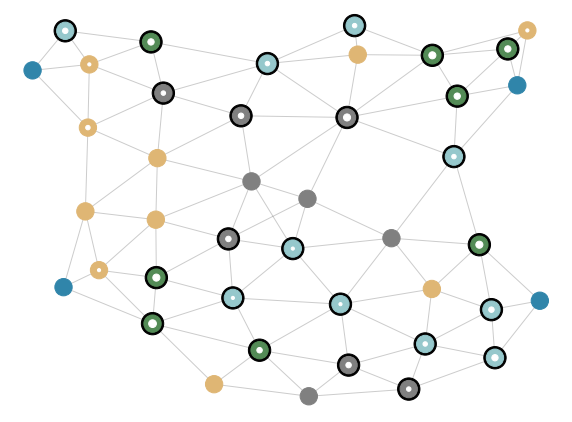

In [8]:
from board_state import BoardState
from invader import Explore, Build, Ravage

game = BoardState(nodes, edges)
actions = [
    Explore(['J', 'M']),
    Build(['J', 'M']),
    Ravage(['J', 'M']),
    Explore(['J', 'W']),
    Build(['J', 'W']),
    Ravage(['J', 'W']),
]

playthrough = game.copy()
print(80*'=')
print('Start')
print(80*'-')
print(playthrough)

for action in actions:
    playthrough = playthrough.apply(action)
    print(80*'=')
    print(action)
    print(80*'-')
    print(playthrough)

In [9]:
def heat_plot(board, value):
    pos = nx.spring_layout(
        board, 
        iterations = 100, 
        pos = {
            ('northwest', 3): (0, 10),
            ('northeast', 1): (10, 10),
            ('west', 1): (0, 0), 
            ('east', 3): (0, 10), 
        }, 
        seed = 5,
    )

    plt.figure(figsize=(15, 11))
    edge_plot = nx.draw_networkx_edges(board, pos, alpha=0.2)
    node_plot = nx.draw_networkx_nodes(
        board, pos, board.nodes, 
        node_color = value,
        cmap = plt.cm.jet,
    )
    plt.colorbar(node_plot, orientation='horizontal', aspect=50)
    plt.suptitle('How often a node lies on the shortest path between other nodes', font='Ubuntu', fontsize=16)
    plt.axis('off')
    plt.show()

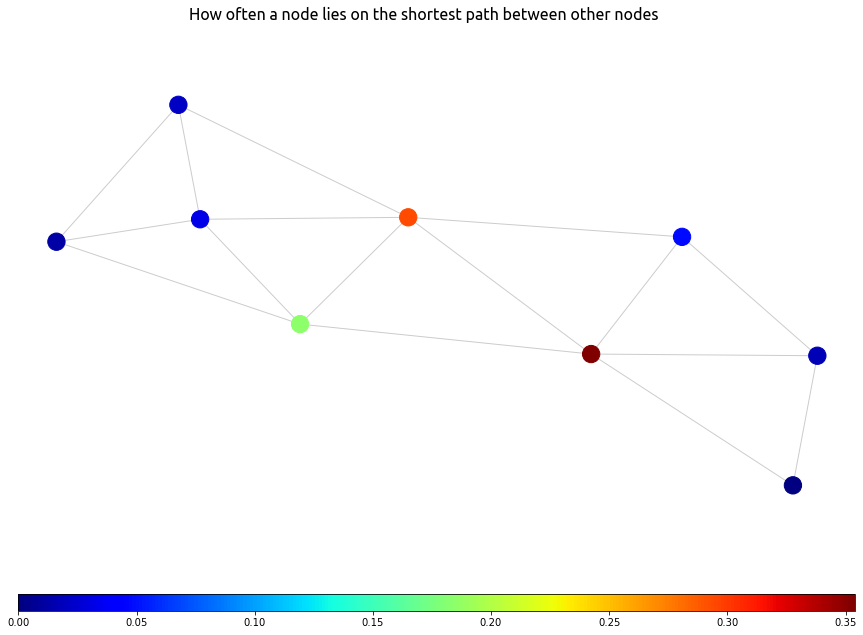

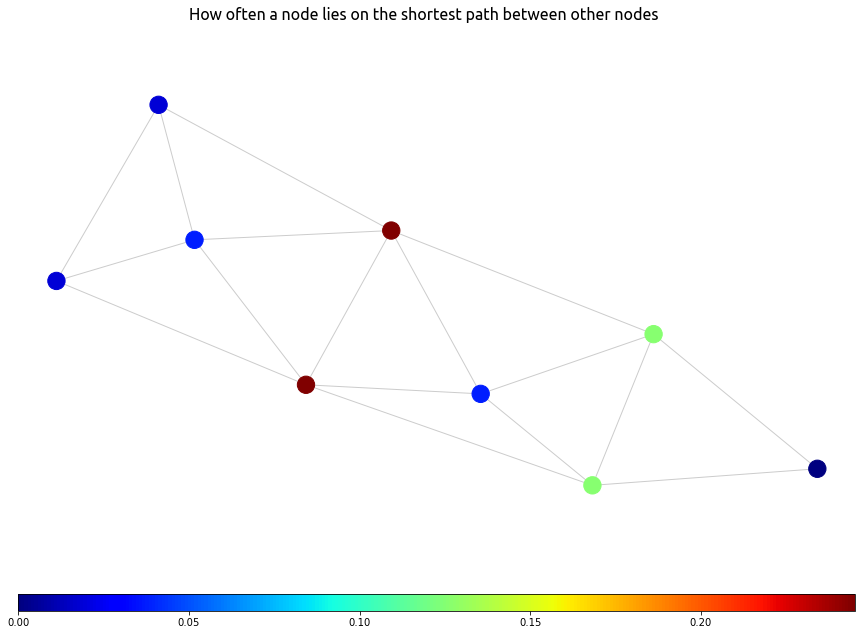

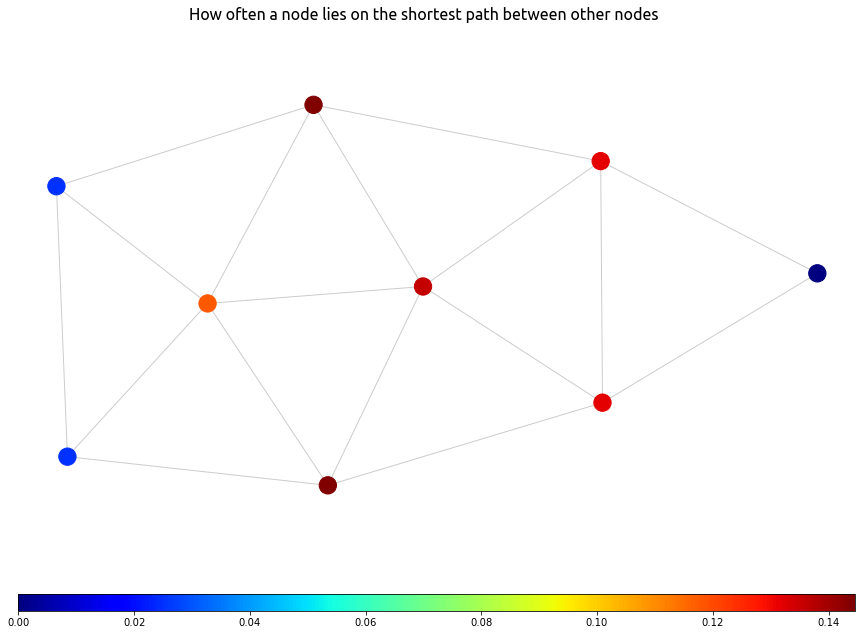

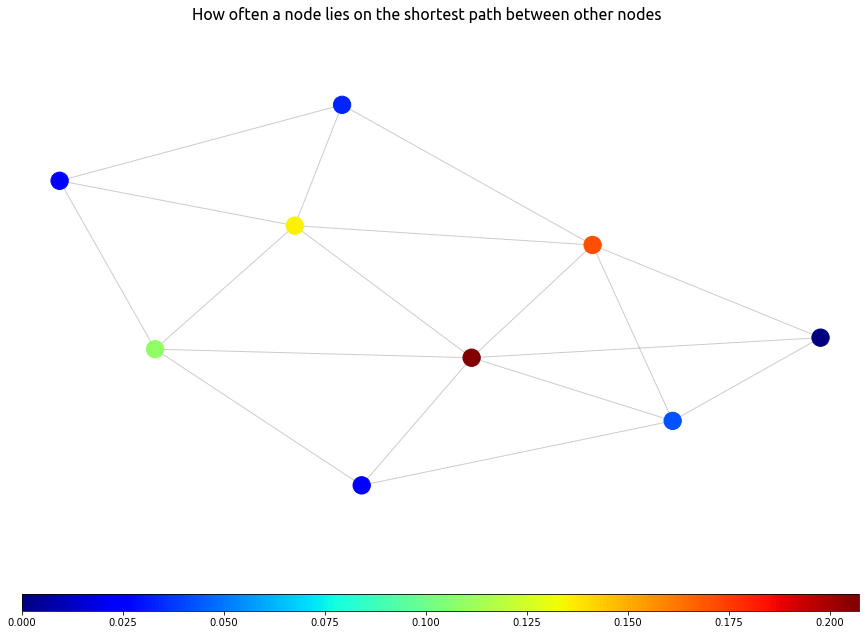

In [10]:
for x in 'ABCD':
    V, E = prepare_data(boards[[x]].to_dict(), adjacency[[x]].to_dict())
    B = BoardState(V, E)
    G = B.network

    c_b = pd.Series(nx.betweenness_centrality(G))
    heat_plot(G, c_b.values)

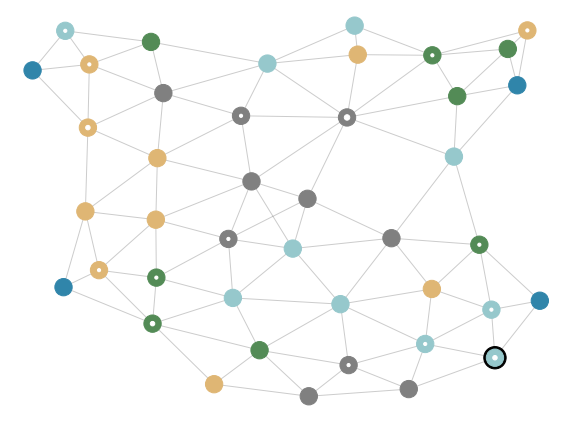

In [11]:
game

In [12]:
A = BoardState(*prepare_data(boards[['A']], adjacency[['A']]))
B = BoardState(*prepare_data(boards[['B']], adjacency[['B']]))
C = BoardState(*prepare_data(boards[['C']], adjacency[['C']]))
D = BoardState(*prepare_data(boards[['D']], adjacency[['D']]))

In [13]:
pd.Series(nx.betweenness_centrality_source(
    game.network, 
    sources = game.nodes.index[(game.nodes['id'] == 0) | game.nodes[['towns', 'cities']].any(axis=1)]
)).groupby(level=0).sum().sort_values(ascending=False)

northwest    0.239818
northeast    0.217059
east         0.205668
west         0.171601
dtype: float64

In [14]:
game.nodes.index[game.nodes['land'].isin(['O']) | game.building_count.any(axis=1)]

Index([     ('east', 0),      ('east', 2),      ('east', 3), ('northeast', 0),
       ('northeast', 1), ('northeast', 5), ('northwest', 0), ('northwest', 2),
       ('northwest', 3),      ('west', 0),      ('west', 1),      ('west', 2)],
      dtype='object', name='node')

# Explore reach

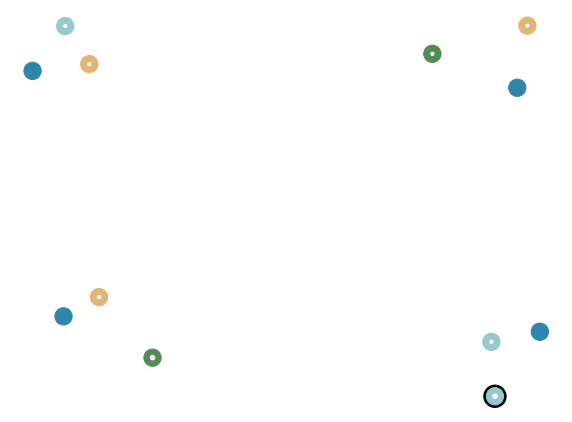

In [15]:
ego_2 = game.ego(game.invader_sources, degree=0)
ego_2.pos = game.pos
ego_2

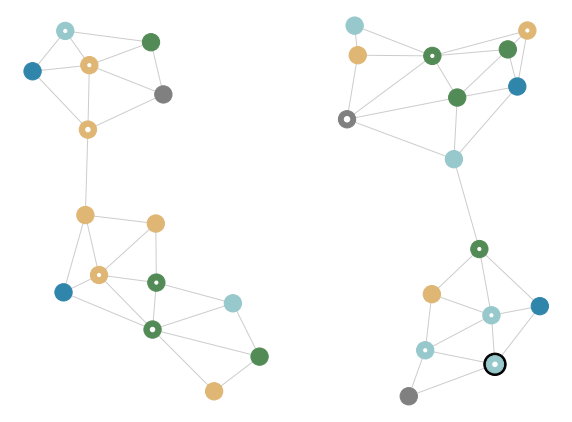

In [16]:
ego_1 = game.ego(game.invader_sources, degree=1.5)
ego_1.pos = game.pos
ego_1

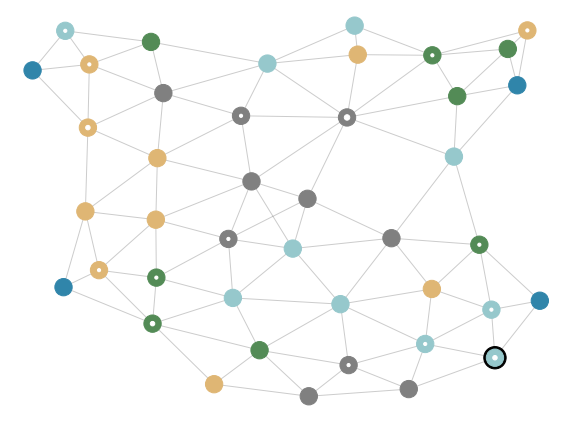

In [17]:
ego_2 = game.ego(game.invader_sources, degree=2.5)
ego_2.pos = game.pos
ego_2

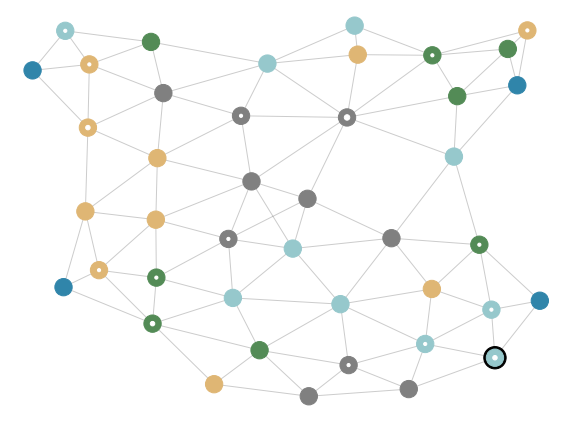

In [18]:
game

In [19]:
A = BoardState(*prepare_data(boards[['A']], adjacency[['A']]))
B = BoardState(*prepare_data(boards[['B']], adjacency[['B']]))
C = BoardState(*prepare_data(boards[['C']], adjacency[['C']]))
D = BoardState(*prepare_data(boards[['D']], adjacency[['D']]))
NE = BoardState(*prepare_data(boards[['northeast']], adjacency[['northeast']]))
NW = BoardState(*prepare_data(boards[['northwest']], adjacency[['northwest']]))
E = BoardState(*prepare_data(boards[['east']], adjacency[['east']]))
W = BoardState(*prepare_data(boards[['west']], adjacency[['west']]))

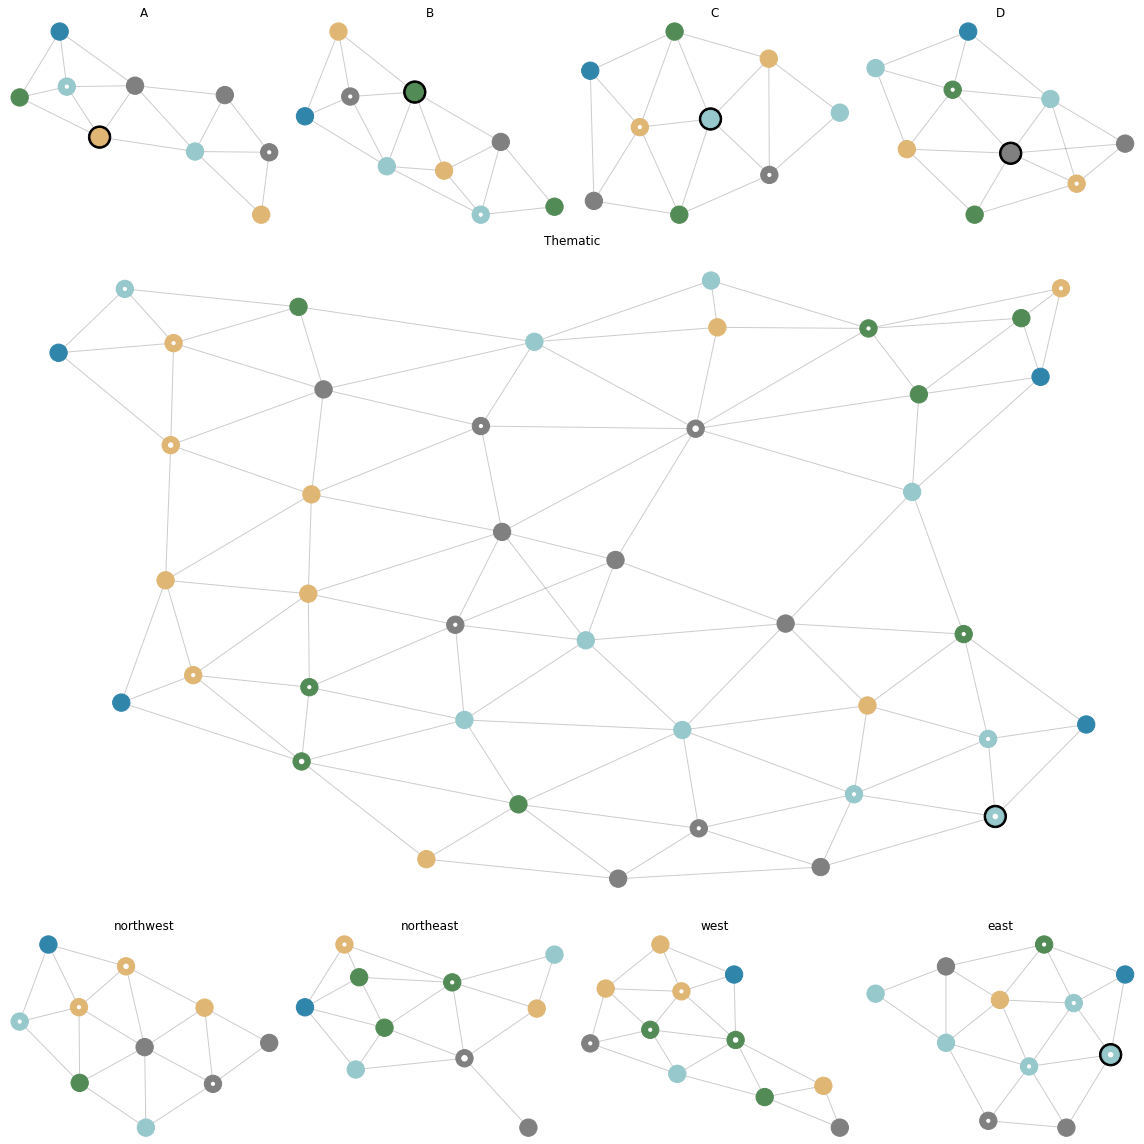

In [20]:
fig, axs = plt.subplots(ncols=4, nrows=5, figsize=(16, 16))
for ax in axs[1:4, :].flat:
    ax.remove()

gs = axs[0,0].get_gridspec()
ax = fig.add_subplot(gs[1:4, :])
ax.set_title('Thematic')
ax.axis('off')
game.draw(ax=ax)

for i, board in enumerate([A, B, C, D]):
    ax = axs[0, i]
    ax.set_title(board.nodes.board.iloc[0])
    ax.axis('off')
    board.draw(ax=ax)
    
for i, board in enumerate([NW, NE, W, E]):
    ax = axs[-1, i]
    ax.set_title(board.nodes.board.iloc[0])
    ax.axis('off')
    board.draw(ax=ax)
    
fig.tight_layout()